<a href="https://colab.research.google.com/github/fianadew/time-series/blob/main/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SUBMISSION 2 PENGEMBANGAN MACHINE LEARNING

NAMA : FIANA DEWI

In [ ]:
import os
import re
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import missingno as msno
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Membaca file csv train
df = pd.read_csv("/content/drive/My Drive/testset.csv", parse_dates=['datetime_utc'])

In [ ]:
#Kolom yang digunakan hanya beberapa saja dan 50000 baris
weather_df = df.loc[50000:,['datetime_utc', ' _hum', ' _tempm']]
weather_df.head()

,datetime_utc,_hum,_tempm
50000,2003-10-21 05:00:00,42.0,28.0
50001,2003-10-21 05:30:00,40.0,29.0
50002,2003-10-21 06:00:00,37.0,30.0
50003,2003-10-21 06:30:00,35.0,31.0
50004,2003-10-21 06:53:00,33.0,31.0


In [ ]:
#Mengecek missing values
weather_df.isnull().sum()

datetime_utc      0
 _hum           243
 _tempm         199
dtype: int64

In [ ]:
#menghapus data missing values
weather_df.dropna(inplace=True)
weather_df.isnull().sum()

datetime_utc    0
 _hum           0
 _tempm         0
dtype: int64

In [ ]:
#melihat bentuk data
weather_df.shape

(50747, 3)

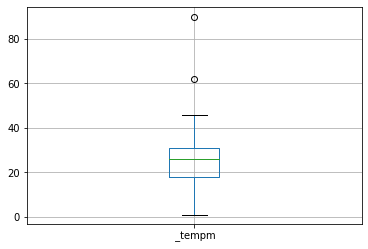

In [ ]:
#grafik boxplot untuk melihat outlier sebelum membuang outlier
weather_df.boxplot(column=' _tempm')
plt.show()

In [ ]:
#Mendeteksi outlier temperature
mean_temp, std_temp = weather_df[' _tempm'].mean(), weather_df[' _tempm'].std()
cut_off = std_temp * 3
lower, upper = mean_temp - cut_off, mean_temp + cut_off
#menghapus outlier
weather_df.drop(weather_df[(weather_df[' _tempm'] >upper)].index, inplace=True)
weather_df.drop(weather_df[(weather_df[' _tempm'] <lower)].index, inplace=True)
#mengecek outlier
outliers_temp = [x for x in weather_df[' _tempm'] if x < lower or x > upper]
outliers_temp

[]

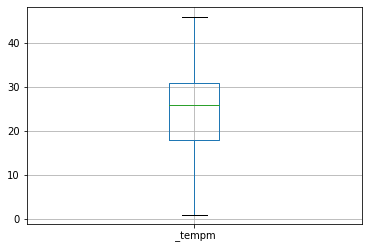

In [ ]:
#grafik boxplot untuk melihat outlier setelah membuang outlier
weather_df.boxplot(column=' _tempm')
plt.show()

In [ ]:
#melihat describe dari data
weather_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_hum,50745.0,57.561553,24.478967,4.0,37.0,58.0,78.0,243.0
_tempm,50745.0,24.988984,8.551071,1.0,18.0,26.0,31.0,46.0


In [ ]:
#menghitung maksimal mae yang ditentukan yaitu < 10%
max_mae = (46.0 - 1.0)*0.1
max_mae

4.5

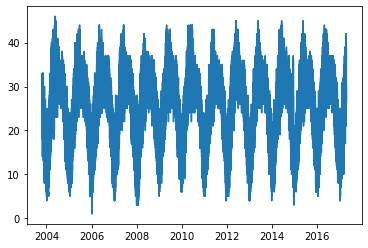

In [ ]:
#membuat graik
weather = weather_df[' _tempm'].values
datetime = weather_df['datetime_utc'].values
plt.plot( datetime, weather)

In [ ]:
#mengubah tipe data menjadi float
weather = weather.astype('float32')
weather.reshape(-1, 1)

array([[28.],
       [29.],
       [30.],
       ...,
       [36.],
       [32.],
       [30.]], dtype=float32)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(weather, datetime, test_size = 0.2, shuffle = False )

In [ ]:
#window 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
#memasukkan nilai fungsi
train_set = windowed_dataset(x_train, window_size=20, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(x_valid, window_size=20, batch_size=200, shuffle_buffer=1000)

In [ ]:
#membuat pemodelan sequential
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
#membuat fungsi compile optimizer dan loss
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#membuat callbacks
#class myCallback(tf.keras.callbacks.Callback):
  #def on_epoch_end(self, epoch, logs={}):
   # if(logs.get('mae')< max_mae and logs.get('val_mae')<max_mae):
    #  print("\nMAE dari model < 10% skala data")
     # self.model.stop_training = True
#callbacks = myCallback()

In [ ]:
history = model.fit(train_set, epochs=10, validation_data = test_set)

Epoch 1/10
203/203 [==============================] - 24s 98ms/step - loss: 23.1088 - mae: 23.6088 - val_loss: 22.9927 - val_mae: 23.4927
Epoch 2/10
203/203 [==============================] - 19s 91ms/step - loss: 12.9141 - mae: 13.4071 - val_loss: 5.9495 - val_mae: 6.4340
Epoch 3/10
203/203 [==============================] - 19s 91ms/step - loss: 6.0845 - mae: 6.5678 - val_loss: 4.6488 - val_mae: 5.1336
Epoch 4/10
203/203 [==============================] - 18s 90ms/step - loss: 3.4012 - mae: 3.8728 - val_loss: 3.3203 - val_mae: 3.7986
Epoch 5/10
203/203 [==============================] - 19s 91ms/step - loss: 3.1929 - mae: 3.6614 - val_loss: 3.2103 - val_mae: 3.6871
Epoch 6/10
203/203 [==============================] - 19s 91ms/step - loss: 2.9665 - mae: 3.4317 - val_loss: 3.1438 - val_mae: 3.6182
Epoch 7/10
203/203 [==============================] - 19s 91ms/step - loss: 2.8595 - mae: 3.3224 - val_loss: 3.1565 - val_mae: 3.6292
Epoch 8/10
203/203 [==============================] - 18

No handles with labels found to put in legend.


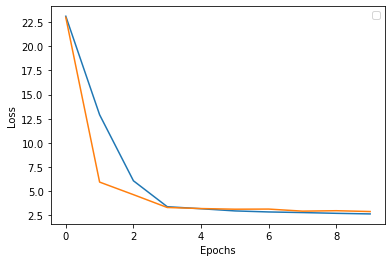

In [ ]:
#membuat plotting grafik loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


No handles with labels found to put in legend.


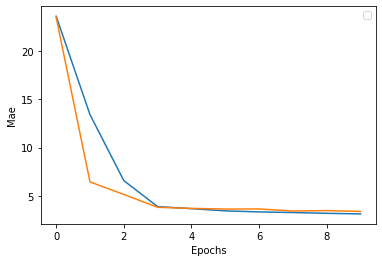

In [ ]:
#membuat plotting grafik mae
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(mae)
plt.plot(val_mae)
plt.ylabel('Mae')
plt.xlabel('Epochs')
plt.legend()
plt.show()